Check how many sites can have a better mutation; And the number of total positive mutation

In [1]:
import pandas as pd

# load your mutation results
df = pd.read_csv("/home/eva/0_point_mutation/results/antifold/vhh_antifold.csv", sep="\t")

summary = []

for sample in df["sample"].unique():
    subset = df[df["sample"] == sample]
    positive = subset[subset["delta_log_likelihood"] > 0]
    
    n_positions_with_positive_delta = positive[["chain", "pos"]].drop_duplicates().shape[0]
    n_total_positive_mutations = positive.shape[0]
    
    best_per_position = (
        positive
        .groupby(["chain", "pos"])
        ["delta_log_likelihood"]
        .max()
        .mean()
    )
    
    summary.append({
        "sample": sample,
        "n_positions_with_positive_delta": n_positions_with_positive_delta,
        "n_total_positive_mutations": n_total_positive_mutations,
        "mean_best_positive_delta": best_per_position
    })

summary_df = pd.DataFrame(summary)
summary_df.to_csv("/home/eva/0_point_mutation/results/mab_summary.csv", sep="\t", index=False)
print("Wrote mab_summary.csv with summary statistics.")


/tmp/ipykernel_722608/934170763.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


KeyError: 'delta_log_likelihood'

KeyError: 'chain'

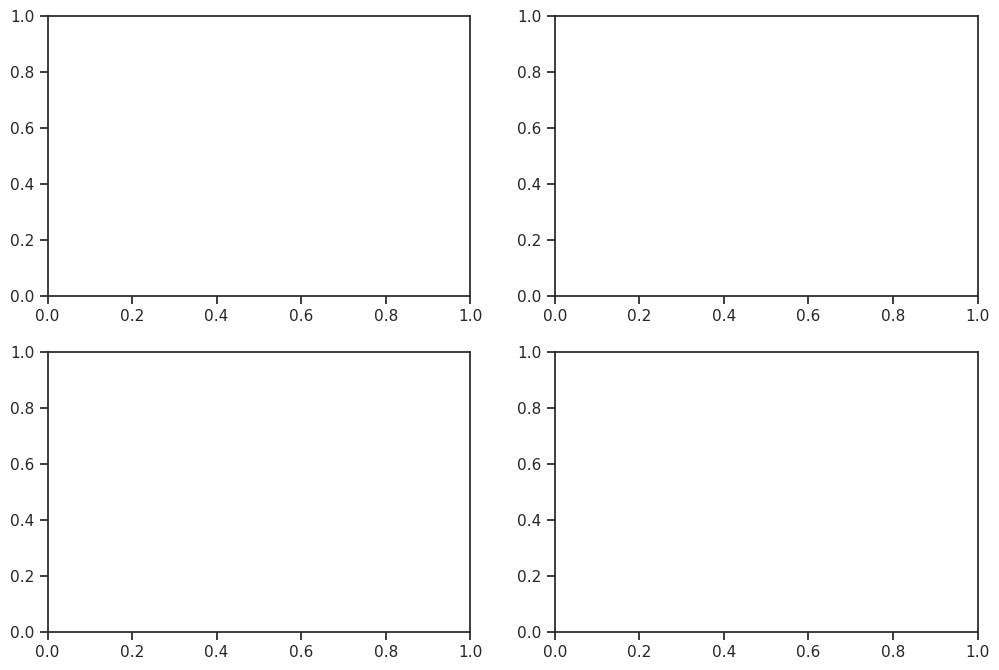

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load your results
df = pd.read_csv("/home/eva/0_point_mutation/results/mab_summary.csv", sep="\t")

# sites of interest
sites = [('VH', 'H103'), ('VH', 'H104'), ('VH', 'H68')]

sns.set_theme(style="ticks")

n_sites = len(sites)
ncols = 2
nrows = (n_sites + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 4))
axes = axes.flatten()

for ax, (chain, pos) in zip(axes, sites):
    site_df = df[(df["chain"] == chain) & (df["imgt_pos"] == pos)]
    if site_df.empty:
        ax.set_title(f"{chain} {pos} (no data)")
        continue

    # violin
    sns.violinplot(
        data=site_df,
        x="mt",
        y="mut_log_likelihood",
        palette="vlag",
        inner=None,
        scale="width",
        cut=0,
        ax=ax
    )

    # scatter on top
    sns.stripplot(
        data=site_df,
        x="mt",
        y="mut_log_likelihood",
        color="k",
        size=1,
        alpha=0.8,
        jitter=True,
        ax=ax
    )

    ax.axhline(0, linestyle="--", color="gray")
    ax.set_title(f"{chain} position {pos} mutation scan")
    ax.set_xlabel("Mutant amino acid")
    ax.set_ylabel("mut_log_likelihood")

sns.despine()
plt.tight_layout()
plt.savefig("multi_site_mutscan_violin.png", dpi=300)
plt.close()
print("Wrote multi_site_mutscan_violin.png")


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# load results
df = pd.read_csv("/home/eva/0_point_mutation/results/antifold/vhh_antifold.csv", sep="\t")
df['mut_log_likelihood'].isna()

0          False
1          False
2          False
3          False
4          False
           ...  
4177848    False
4177849    False
4177850    False
4177851    False
4177852    False
Name: mut_log_likelihood, Length: 4177853, dtype: bool

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re

# Load
df = pd.read_csv("/home/eva/0_point_mutation/results/antifold/vhh_antifold.csv", sep="\t")

print("Columns in dataframe:", df.columns.tolist())

sns.set_theme(style="ticks")

unique_sites = df[["chain", "kabat_pos"]].drop_duplicates()

# extract real chain and number
def parse_site(row):
    kabat_pos = str(row["kabat_pos"])
    chain_orig = str(row["chain"]).upper()
    # extract chain from kabat_pos, e.g. H100A
    m = re.match(r"([HL])(\d+)([A-Za-z]?)", kabat_pos)
    if m:
        chain_code = m.group(1)
        pos_num = int(m.group(2))
        pos_letter = m.group(3) or ""
        return chain_code, pos_num, pos_letter
    else:
        # fallback
        return "pos", 0, ""
    
def sort_key(row):
    chain_code, pos_num, pos_letter = parse_site(row)
    if chain_code == "H":
        return (0, pos_num, pos_letter)
    elif chain_code == "L":
        return (1, pos_num, pos_letter)
    elif chain_code == "pos":
        return (2, 0, "")
    else:
        return (3, pos_num, pos_letter)

# sort
unique_sites_sorted = unique_sites.copy()
unique_sites_sorted["sort_order"] = unique_sites_sorted.apply(sort_key, axis=1)
unique_sites_sorted = unique_sites_sorted.sort_values(by="sort_order")

# check order
print("Final plotting order:")
print(unique_sites_sorted[["chain", "kabat_pos"]])

# plotting
with PdfPages("all_sites_mutscan_antifold.pdf") as pdf:
    for _, row in unique_sites_sorted.iterrows():
        chain = row["chain"]
        pos = row["kabat_pos"]
        site_df = df[(df["chain"] == chain) & (df["kabat_pos"] == pos)]
        
        plt.figure(figsize=(7, 5))
        
        if site_df.empty or "mut_log_likelihood" not in site_df.columns:
            plt.title(f"{chain} {pos} (no data or missing column)")
            pdf.savefig()
            plt.close()
            continue
        
        sns.violinplot(
            data=site_df,
            x="mt",
            y="mut_log_likelihood",
            palette="vlag",
            inner=None,
            scale="width",
            cut=0
        )
        sns.stripplot(
            data=site_df,
            x="mt",
            y="mut_log_likelihood",
            color="k",
            alpha=0.5,
            size=2,
            jitter=True
        )
        
        plt.axhline(0, linestyle="--", color="gray")
        plt.title(f"{chain} position {pos}", fontsize=12)
        plt.xlabel("Mutant amino acid")
        plt.ylabel("mut_log_likelihood")
        sns.despine()
        plt.tight_layout()
        pdf.savefig()
        plt.close()

print(f"Wrote all_sites_mutscan.pdf with {len(unique_sites_sorted)} pages")


/tmp/ipykernel_42856/3690772326.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Columns in dataframe: ['chain', 'pos', 'wt', 'mt', 'delta_log_likelihood', 'mut_log_likelihood', 'wt_log_likelihood', 'kabat_pos', 'mutation_label', 'sample']
Final plotting order:
        chain kabat_pos
0          VH        H1
19         VH        H2
38         VH        H3
57         VH        H4
76         VH        H5
...       ...       ...
4104       VL      L105
4123       VL      L106
1118207    VL      L107
607183     VH       NaN
4160886    VL       NaN

[281 rows x 2 columns]


/tmp/ipykernel_42856/3690772326.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_42856/3690772326.py:66: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_42856/3690772326.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_42856/3690772326.py:66: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_42856/3690772326.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed 

Wrote all_sites_mutscan.pdf with 281 pages


In [2]:
import pandas as pd
import glob

# adjust this to your folder path
file_list = glob.glob('/home/eva/0_point_mutation/results/antiberta/*.csv')

# read and combine all csv files
df_list = [pd.read_csv(file) for file in file_list]
combined_df = pd.concat(df_list, ignore_index=True)

# save the result
combined_df.to_csv('/home/eva/0_point_mutation/results/antiberta/vhh_antibert.csv', index=False)


# Plot multiple point mutations

In [3]:
import pandas as pd

df = pd.read_csv("csv_folder/vhh_antiberta.csv")
print(df.columns.tolist())


['chain\tpos\twt\tmt\tmut_log_likelihood_antiberta\twt_log_likelihood_antiberta\tdelta_log_likelihood_antiberta\tsample']


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

# collect all CSVs
files = glob.glob('csv_folder/*.csv')

dfs = []
for file in files:
    df = pd.read_csv(file)
    if len(df.columns) == 1:
        df = pd.read_csv(file, sep="\t")
    delta_cols = [col for col in df.columns if "delta_log_likelihood" in col]
    if len(delta_cols) == 0:
        raise ValueError(f"No delta_log_likelihood columns in {file} with columns: {df.columns.tolist()}")
    modelname = delta_cols[0].split('_')[-1].strip()
    df['model'] = modelname
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

all_delta_cols = [col for col in data.columns if col.startswith("delta_log_likelihood")]

melted = data.melt(
    id_vars=[c for c in ['chain','pos','wt','mt','sample','model'] if c in data.columns],
    value_vars=all_delta_cols,
    var_name='delta_type',
    value_name='delta_value'
)

melted = melted[melted.apply(lambda x: x['delta_type'].endswith(x['model']), axis=1)]

# pivot to get summed score
pivot = melted.pivot_table(
    index=["chain","pos","wt","mt","sample"],
    columns="model",
    values="delta_value"
).reset_index()

# adjust ablang2
if "ablang2" in pivot.columns:
    pivot["ablang2"] = 0.5 * pivot["ablang2"]

model_cols = [c for c in pivot.columns if c not in ["chain","pos","wt","mt","sample"]]
pivot["delta_value"] = pivot[model_cols].sum(axis=1)
pivot["model"] = "sum"

# match the melt format
sum_melted = pivot[["chain","pos","wt","mt","sample","model","delta_value"]]

# combine
combined = pd.concat([melted, sum_melted], ignore_index=True)

# make one FacetGrid with all models + sum
for sample_name, df_sample in combined.groupby("sample"):
    g = sns.FacetGrid(
        df_sample,
        col="model",
        col_wrap=3,
        height=5,
        sharey=False
    )
    
    def scatter_with_cutoff(data, color, **kwargs):
        plt.axhline(0, linestyle="--", color="gray")
        filtered_data = data[data["delta_value"] != 0]
        sns.scatterplot(
            data=filtered_data,
            x="pos",
            y="delta_value",
            color=color,
            alpha=0.7,
            **kwargs
        )
        plt.yscale("symlog", linthresh=1)

        # annotate top1 positive per site
        for pos in filtered_data["pos"].unique():
            site_df = filtered_data[(filtered_data["pos"] == pos) & (filtered_data["delta_value"] > 0)]
            top1 = site_df.nlargest(1, "delta_value")
            for _, row in top1.iterrows():
                plt.text(
                    row["pos"] + 0.2,
                    row["delta_value"] + 0.1,
                    row["mt"],
                    fontsize=8,
                    color=color,
                    fontweight="bold"
                )
    
    g.map_dataframe(scatter_with_cutoff)
    g.set_axis_labels("Position", "Delta log likelihood")
    g.set_titles("{col_name}")
    g.fig.suptitle(f"{sample_name} - All models + sum", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{sample_name}_all_models_and_sum.png", dpi=300)
    plt.close()


# A pipeline to extract delta > 0 for all models and calclate rmsd

Step 1: Identify consensus-bad mutations

In [29]:
%pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 15.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.6/371.6 kB 11.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from abnumber import Chain
import glob

# collect all CSVs
files = glob.glob('csv_folder/mab/*.csv')
dfs = []

for file in files:
    df = pd.read_csv(file)
    if len(df.columns) == 1:
        df = pd.read_csv(file, sep="\t")

    delta_cols = [col for col in df.columns if "delta_log_likelihood" in col]
    if not delta_cols:
        raise ValueError(f"No delta_log_likelihood columns in {file} with columns: {df.columns.tolist()}")

    modelname = delta_cols[0].split('_')[-1].strip()
    df['model'] = modelname

    rename_map = {
        'chain': 'chain', 'Chain': 'chain', 'CH': 'chain',
        'pos': 'pos', 'Pos': 'pos', 'position': 'pos',
        'wt': 'wt', 'WT': 'wt',
        'mt': 'mt', 'MT': 'mt',
        'sample': 'sample', 'Sample': 'sample'
    }
    df.rename(columns={c: rename_map.get(c, c) for c in df.columns}, inplace=True)

    if 'chain' in df.columns:
        df['chain'] = df['chain'].replace({'VH': 'H'})

    if 'pos' in df.columns:
        df = df[df['pos'].notna()]
        df['pos'] = df['pos'].astype(int)

    wanted = [c for c in df.columns if c in ['chain', 'pos', 'wt', 'mt', 'sample'] or c.startswith("delta_log_likelihood")]
    wanted += ['model']
    df = df[wanted]
    dfs.append(df)

# combine
data = pd.concat(dfs, ignore_index=True)

# melt
delta_cols = [c for c in data.columns if c.startswith("delta_log_likelihood")]
melted = data.melt(
    id_vars=['chain','pos','wt','mt','sample','model'],
    value_vars=delta_cols,
    var_name='delta_type',
    value_name='delta_value'
)

# match delta/model
melted = melted[melted.apply(lambda x: x['delta_type'].endswith(x['model']), axis=1)]

# sum across models
pivot = melted.pivot_table(
    index=["pos","wt","mt","sample"],
    columns="model",
    values="delta_value"
).reset_index()

# scaling
# conditional scaling for ablang and antiberta
if "ablang" in pivot.columns:
    pivot["ablang"] = pivot["ablang"].where(pivot["ablang"] <= 0, (pivot["ablang"] - 5) * 0.5)

if "antiberta" in pivot.columns:
    pivot["antiberta"] = pivot["antiberta"].where(pivot["antiberta"] <= 0, pivot["antiberta"] * 10)


model_cols = [c for c in pivot.columns if c not in ["pos","wt","mt","sample"]]
pivot["delta_value"] = pivot[model_cols].sum(axis=1)
pivot["model"] = "sum"
pivot["chain"] = "H"

sum_melted = pivot[["chain","pos","wt","mt","sample","model","delta_value"]]
combined = pd.concat([melted, sum_melted], ignore_index=True)
combined = combined[~combined['chain'].isin(['L','VL'])]

# --- Pre-filter combined to remove antiberta delta_value <= 0 before plotting ---
filtered = []
for model, group in combined.groupby("model"):
    if model == "antiberta":
        filtered.append(group[group["delta_value"] > 0])
    else:
        filtered.append(group)
combined_filtered = pd.concat(filtered, ignore_index=True)

# rebuild WT sequence
wt_seq_df = combined_filtered.groupby("pos").first().reset_index()[['pos','wt']]
max_pos = wt_seq_df['pos'].max()
wt_sequence = ["X"] * max_pos
for _, row in wt_seq_df.iterrows():
    wt_sequence[row['pos']-1] = row['wt']
wt_sequence = "".join(wt_sequence)

# abnumber to get Kabat
heavy_chain = Chain(wt_sequence, scheme="kabat")
cdrs = heavy_chain.regions
cdr_ranges = {}
for region, positions in cdrs.items():
    if "CDR" in region:
        pos_keys = sorted(positions.keys())
        cdr_ranges[region] = (pos_keys[0], pos_keys[-1])

# mapping seq pos to Kabat
seq_pos_to_kabat_res = {}
for seq_idx, (pos_obj, aa) in enumerate(heavy_chain.positions.items(), start=1):
    seq_pos_to_kabat_res[seq_idx] = f"{pos_obj}{aa}"

# thresholds per model
thresholds = {
    "ablang": 0,
    # add other models if needed
}

# plotting
for sample_name, df_sample in combined_filtered.groupby("sample"):
    df_all = df_sample.copy()

    # top 20% negative per position
    keep_neg = []
    for pos, group in df_all[df_all["delta_value"] < 0].groupby("pos"):
        n_keep = max(1, int(len(group)*0.2))
        top_neg = group.nsmallest(n_keep, "delta_value")
        keep_neg.append(top_neg)

    if keep_neg:
        df_neg = pd.concat(keep_neg, ignore_index=True)
    else:
        df_neg = pd.DataFrame()

    df_plot = pd.concat([df_all, df_neg], ignore_index=True)
    df_plot = df_plot[df_plot["delta_value"] != 0]

    g = sns.FacetGrid(
        df_plot,
        col="model",
        col_wrap=len(df_plot["model"].unique()),
        height=4,
        sharey=False,
        sharex=False
    )

    def scatter_panel(data, color, **kwargs):
        model_name = data["model"].iloc[0]
        threshold = thresholds.get(model_name, 0)

        plt.axhline(threshold, color="gray", linestyle="--")
        
        if model_name == "antiberta":

            sns.scatterplot(
                data=data[(data["delta_value"] > 0) & (data["delta_value"] >= threshold)],
                x="pos",
                y="delta_value",
                color="gray",
                alpha=0.7,
                **kwargs
            )
            # no negatives for antiberta
            
        elif model_name == "sum":

            sns.scatterplot(
                data=data[data["delta_value"] > 0],
                x="pos",
                y="delta_value",
                color="gray",
                alpha=0.7,
                **kwargs
            )

        else:
            sns.scatterplot(
                data=data[data["delta_value"] >= threshold],
                x="pos",
                y="delta_value",
                color="gray",
                alpha=0.7,
                **kwargs
            )

            sns.scatterplot(
                data=data[(data["delta_value"] > 0) & (data["delta_value"] < threshold)],
                x="pos",
                y="delta_value",
                color="gray",
                alpha=0.2,
                **kwargs
            )

            sns.scatterplot(
                data=data[data["delta_value"] < 0],
                x="pos",
                y="delta_value",
                color="gray",
                alpha=0.2,
                **kwargs
            )

        # highlight CDRs
        for cdr, (start, end) in cdr_ranges.items():
            plt.axvspan(
                start.number,
                end.number,
                color="pink",
                alpha=0.2
            )

        # annotate top positive per position
        max_delta = data["delta_value"].max()
        offset_pos = 0.02 * max_delta if max_delta > 0 else 0.02
        top_positive_positions = []
        for pos in data["pos"].unique():
            top1 = data[(data["pos"]==pos) & (data["delta_value"] >= threshold)].nlargest(1,"delta_value")
            for _, row in top1.iterrows():
                plt.text(
                    row["pos"] + 0.2,
                    row["delta_value"] + offset_pos,
                    row["mt"],
                    fontsize=8,
                    color="pink",
                    fontweight="bold"
                )
                top_positive_positions.append(pos)

        # annotate top negative per position
        min_delta = data["delta_value"].min()
        offset_neg = 0.02 * abs(min_delta) if min_delta < 0 else 0.02
        for pos in data["pos"].unique():
            top1_neg = data[(data["pos"]==pos) & (data["delta_value"] < 0)].nsmallest(1,"delta_value")
            for _, row in top1_neg.iterrows():
                plt.text(
                    row["pos"] + 0.2,
                    row["delta_value"] - offset_neg,
                    row["mt"],
                    fontsize=8,
                    color="grey",
                    fontweight="bold"
                )

        # xticks: only label positions that had top positive (pink) labels
        positions = sorted(top_positive_positions)
        labels = []
        prev_pos = None
        for pos in positions:
            if prev_pos is None or pos != prev_pos + 1:
                kabat_label = seq_pos_to_kabat_res.get(pos, f"{pos}?")
                labels.append(kabat_label)
            else:
                labels.append("")
            prev_pos = pos
        plt.xticks(positions, labels, fontsize=7, rotation=90)

    g.map_dataframe(scatter_panel)
    g.set_axis_labels("Kabat Position + WT residue", "Delta log likelihood")
    g.set_titles("{col_name}")
    g.fig.suptitle(f"{sample_name} - Positives (custom threshold & transparency) + top 20% negative", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(f"{sample_name}_pos_top20neg.png", dpi=300)
    plt.close()

print("All plots generated with weak positives transparent and ablang threshold of 5.")


/home/eva/miniconda3/envs/antibody_prediction_safe/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_873197/3785242962.py:264: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/home/eva/miniconda3/envs/antibody_prediction_safe/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_873197/3785242962.py:264: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


All plots generated with weak positives transparent and ablang threshold of 5.


Step 2: Generate mutated FASTA sequences

In [54]:
from Bio import SeqIO

# load your wildtype nanobody FASTA
wt_record = SeqIO.read("wildtype.fasta", "fasta")
wt_seq = list(str(wt_record.seq))

# load consensus bad mutations
consensus = pd.read_csv("consensus_good_mutations.csv")

for _, row in consensus.iterrows():
    pos = int(row["pos"]) - 1  # assuming 1-indexed
    mt = row["mt"]
    mut_seq = wt_seq.copy()
    mut_seq[pos] = mt
    mut_str = "".join(mut_seq)

    outname = f"{row['sample']}_pos{row['pos']}_{row['wt']}to{mt}.fasta"
    SeqIO.write(
        SeqIO.SeqRecord(
            SeqIO.Seq(mut_str),
            id=outname.replace(".fasta",""),
            description=""
        ),
        outname,
        "fasta"
    )


FileNotFoundError: [Errno 2] No such file or directory: 'wildtype.fasta'

Step 3: Run ABodyBuilder2

In [ ]:
abodybuilder2 --fasta your_mutated.fasta --outdir predictions/

Step 4: Calculate RMSD

In [ ]:
import pymol2
import pandas as pd
import glob

wt_pdb = "wildtype.pdb"

rmsd_results = []

with pymol2.PyMOL() as pymol:
    pymol.cmd.load(wt_pdb, "wt")

    for pdb in glob.glob("predictions/*.pdb"):
        name = pdb.split("/")[-1].replace(".pdb","")
        pymol.cmd.load(pdb, name)
        # align and get RMSD
        alignment = pymol.cmd.align(name, "wt")
        rmsd = alignment[0]
        print(f"{name}: RMSD = {rmsd:.3f} Å")

        # parse out mutation details from the filename
        # assuming your prediction filenames are like sample_pos12_EtoK.pdb
        # you can adapt this if needed
        parts = name.split("_")
        sample = parts[0]
        pos = int(parts[1].replace("pos",""))
        mt = parts[2].split("to")[1]
        wt = parts[2].split("to")[0][-1]
        
        rmsd_results.append({
            "sample": sample,
            "pos": pos,
            "wt": wt,
            "mt": mt,
            "rmsd": rmsd
        })

# save to CSV
pd.DataFrame(rmsd_results).to_csv("rmsd_results.csv", index=False)


Step 5: Plotting delta sum vs RMSD

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# read in your consensus mutation deltas
delta_df = pd.read_csv("consensus_good_mutations.csv")

# sum across delta columns to get a total delta score
delta_cols = [c for c in delta_df.columns if c.startswith("delta_log_likelihood")]
delta_df["total_delta"] = delta_df[delta_cols].sum(axis=1)

# read your rmsd results
rmsd_df = pd.read_csv("rmsd_results.csv")

# merge
merged = pd.merge(
    delta_df,
    rmsd_df,
    on=["sample", "pos", "wt", "mt"]
)

# plot
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    merged["total_delta"],
    merged["rmsd"],
    c=merged["pos"],   # color points by position for clarity
    cmap="viridis",
    s=80,
    alpha=0.8
)
plt.colorbar(scatter, label="Position")
plt.xlabel("Total delta log likelihood (sum of all models)")
plt.ylabel("RMSD (Å) to wild-type")
plt.title("Consensus-bad mutations: total delta vs. RMSD")

# annotate with mutation code
for _, row in merged.iterrows():
    plt.text(
        row["total_delta"] + 0.05,
        row["rmsd"],
        row["mt"],
        fontsize=8,
        color="black"
    )

plt.tight_layout()
plt.savefig("delta_vs_rmsd.png", dpi=300)
plt.show()
